In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




In [256]:
df = pd.read_csv('/Users/mikeredshaw/Downloads/data_set_hackathon.csv')

In [257]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


Convert dates to datetime

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [259]:
df.fillna(0, inplace=True)

In [260]:
df.replace(r'\N', 0, inplace=True
)


In [261]:
df.rename(columns={'order_date': 'Order Date', 'requested_delivery_date': 'Requested Delivery Date', 'order_type': 'Order Type', 'value': 'Value', 'Curr': 'Currency', 'items': 'Items'}, inplace=True)



In [262]:
negative_rows = df[df['Value'] < 0]
print(negative_rows)


     Order Date Requested Delivery Date Customer Country Code Product Code  \
929  28.02.2011              15.09.2011                    CH    L12136100   

                     Description Order Type  Customer Order Code  Value  \
929  Parka Outdoor Lifestyle STD         VO           3200633089  -0.03   

    Currency Items   Route  
929      CHF     0  CH0001  


In [263]:
df = df[df['Value'] >= 0]

In [264]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

df['Delivery Year'] = df['Requested Delivery Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month

In [265]:
df.dtypes

Order Date                 datetime64[ns]
Requested Delivery Date    datetime64[ns]
Customer Country Code              object
Product Code                       object
Description                        object
Order Type                         object
Customer Order Code                 int64
Value                             float64
Currency                           object
Items                              object
Route                              object
Order Year                          int64
Order Month                         int64
Delivery Year                       int64
Delivery Month                      int64
dtype: object

In [266]:
df['Order Year'].unique()

array([2009, 2010, 2011, 2012])

In [267]:
df['Delivery Year'].unique()

array([2010, 2011, 2012, 2013])

In [268]:
df['Items'] = df['Items'].astype(int)

In [269]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Order Year,Order Month,Delivery Year,Delivery Month
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,2009,7,2010,1
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,2009,7,2010,3
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,2009,7,2010,2
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,2009,7,2010,2
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,2009,7,2010,2


Review orders on a monthly level.

In [270]:
monthly_orders = df.groupby(['Order Year', 'Order Month']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
monthly_orders = monthly_orders.sort_values(by=['Order Year', 'Order Month'])

In [336]:
monthly_orders_sorted = monthly_orders_sorted.sort_values(by=['Order Year', 'Order Month']).reset_index(drop=True)
monthly_orders_sorted.head(30)


,Order Year,Order Month,Value,Items,Order Year Month
0,2009,7,462065.60,1067,2009-7
1,2009,8,45673.86,137,2009-8
2,2009,9,1692.29,70,2009-9
3,2009,10,97.42,10,2009-10
4,2009,11,12492.89,630,2009-11
5,2009,12,159934.26,361,2009-12
6,2010,1,20266.37,187,2010-1
7,2010,2,74925.83,370,2010-2
8,2010,3,14282.48,314,2010-3
9,2010,4,804.00,81,2010-4


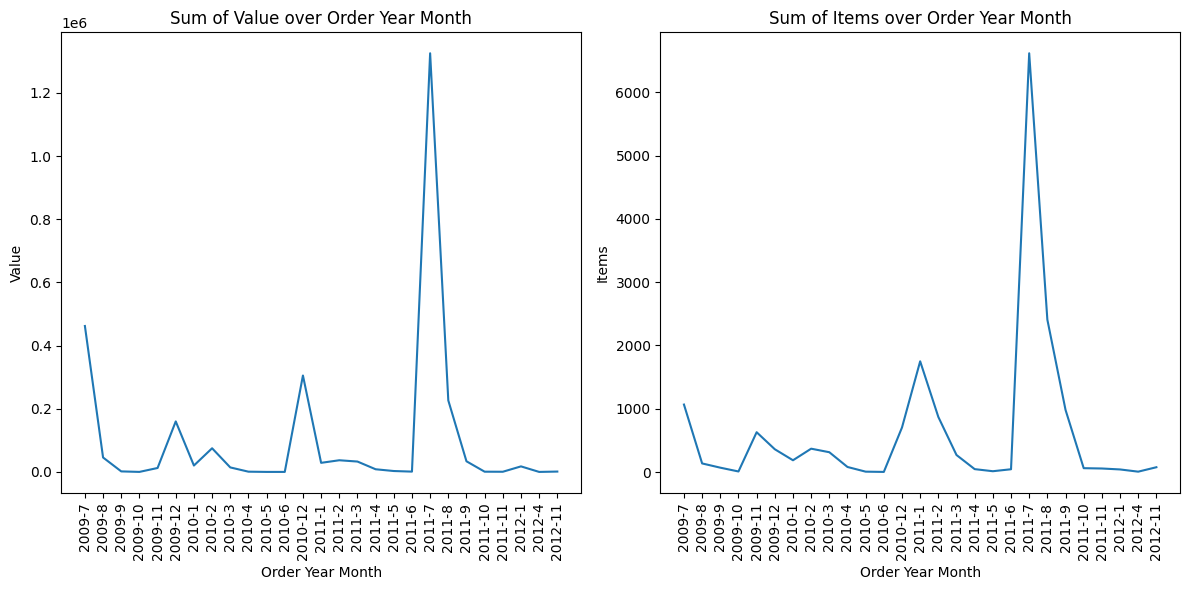

In [272]:
monthly_orders['Order Year Month'] = monthly_orders['Order Year'].astype(str) +"-" + monthly_orders['Order Month'].astype(str)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Value')
plt.xlabel('Order Year Month')
plt.ylabel('Value')
plt.title('Sum of Value over Order Year Month')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_orders, x='Order Year Month', y='Items')
plt.xlabel('Order Year Month')
plt.ylabel('Items')
plt.title('Sum of Items over Order Year Month')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [273]:
monthly_orders['Order Year Month'].unique()

array(['2009-7', '2009-8', '2009-9', '2009-10', '2009-11', '2009-12',
       '2010-1', '2010-2', '2010-3', '2010-4', '2010-5', '2010-6',
       '2010-12', '2011-1', '2011-2', '2011-3', '2011-4', '2011-5',
       '2011-6', '2011-7', '2011-8', '2011-9', '2011-10', '2011-11',
       '2012-1', '2012-4', '2012-11'], dtype=object)

In [274]:
monthly_orders.describe()

,Order Year,Order Month,Value,Items
count,27.000000,27.000000,2.700000e+01,27.000000
mean,2010.407407,6.370370,1.042372e+05,636.703704
std,0.971092,3.628394,2.675117e+05,1329.654808
min,2009.000000,1.000000,4.991000e+01,3.000000
25%,2010.000000,3.500000,8.926400e+02,46.000000
50%,2011.000000,6.000000,1.428248e+04,137.000000
75%,2011.000000,9.500000,4.131585e+04,667.500000
max,2012.000000,12.000000,1.325577e+06,6616.000000


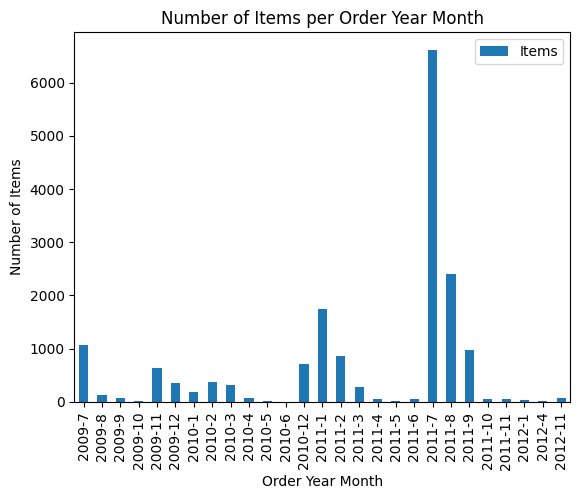

In [275]:
monthly_orders.plot(x='Order Year Month', y='Items', kind='bar')
plt.xlabel('Order Year Month')
plt.ylabel('Number of Items')
plt.title('Number of Items per Order Year Month')
plt.show()


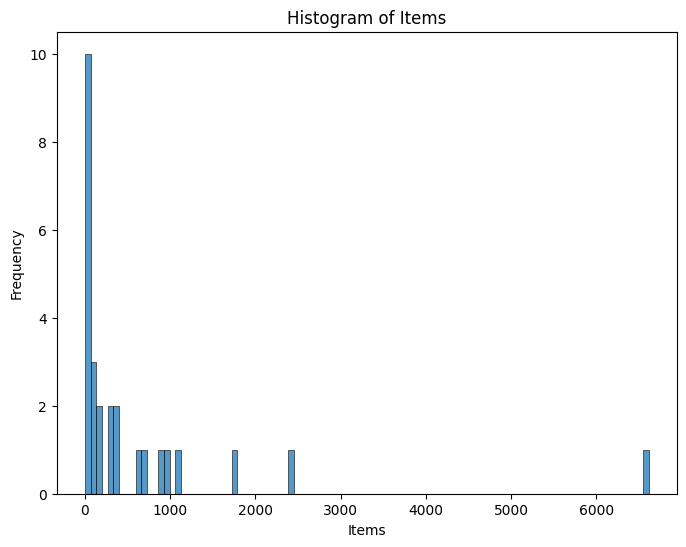

In [276]:
plt.figure(figsize=(8, 6))
sns.histplot(data=monthly_orders, x='Items', bins=100)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Histogram of Items')
plt.show()


Review orders on a seasonal basis.

In [277]:
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df['O_Season'] = df['Order Month'].apply(month_to_season)
df['D_Season'] = df['Delivery Month'].apply(month_to_season)
df['O_Season_Num'] = df['O_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
df['D_Season_Num'] = df['D_Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})
df['Year-Season'] = df['Order Year'].astype(str) + '-' + df['O_Season_Num'].astype(str)

year_season_orders = df.groupby('Year-Season').agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
year_season_orders['Year-Season'] = pd.Categorical(year_season_orders['Year-Season'], categories=sorted(df['Year-Season'].unique()), ordered=True)
year_season_orders = year_season_orders.sort_values('Year-Season')

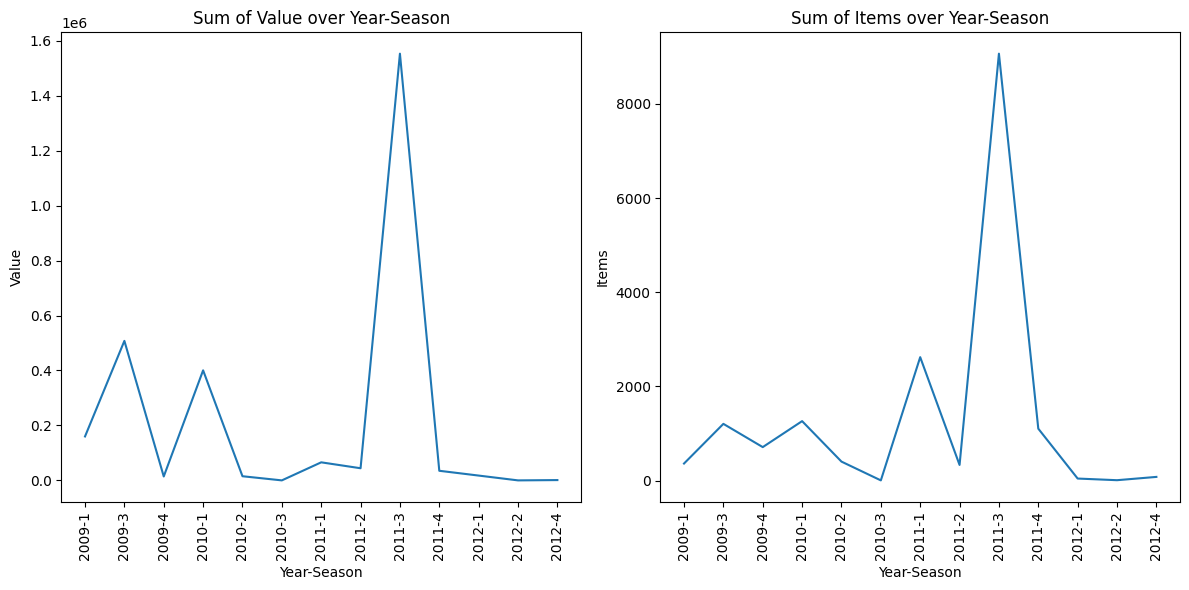

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

year_season_orders = year_season_orders.sort_values('Year-Season')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Value')
plt.xlabel('Year-Season')
plt.ylabel('Value')
plt.title('Sum of Value over Year-Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=year_season_orders, x='Year-Season', y='Items')
plt.xlabel('Year-Season')
plt.ylabel('Items')
plt.title('Sum of Items over Year-Season')
plt.xticks(rotation=90)

plt.tight_layout()


In [279]:
Grouped_D_Season = df.groupby(['Delivery Year', 'D_Season_Num']).agg({'Value': 'sum', 'Items': 'sum'}).reset_index()
Grouped_D_Season['Delivery Year Season'] = Grouped_D_Season['Delivery Year'].astype(str) + '-' + Grouped_D_Season['D_Season_Num'].astype(str)


In [280]:
Grouped_D_Season.head()

,Delivery Year,D_Season_Num,Value,Items,Delivery Year Season
0,2010,1,480163.07,1120,2010-1
1,2010,2,37124.60,164,2010-2
2,2010,3,67007.98,1059,2010-3
3,2010,4,208078.06,894,2010-4
4,2011,1,20612.00,65,2011-1


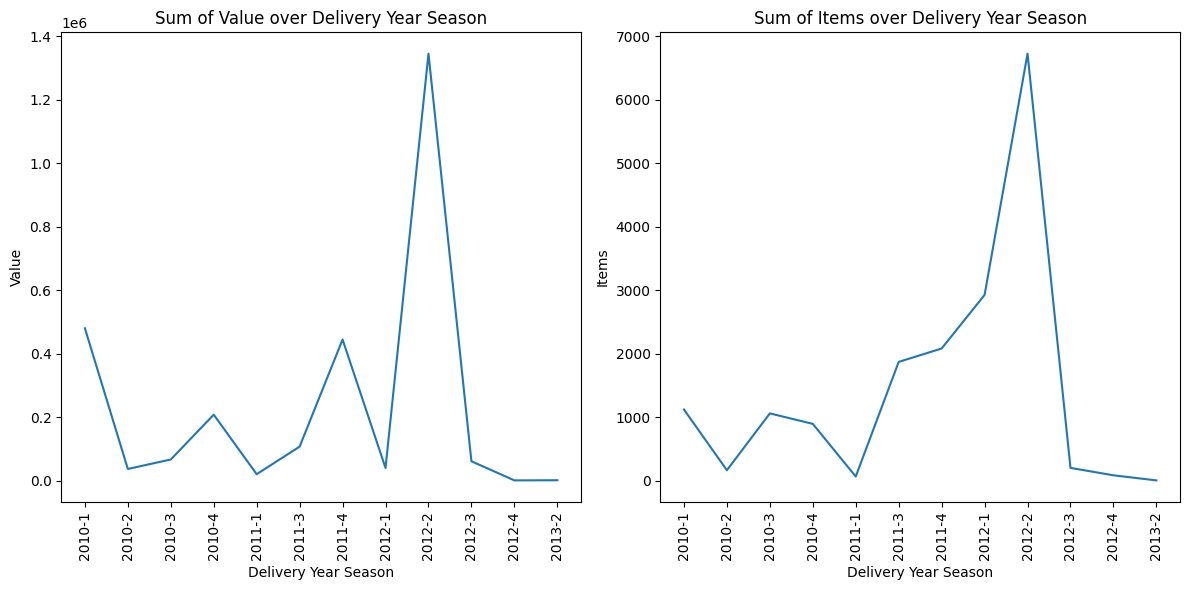

In [281]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Value')
plt.xlabel('Delivery Year Season')
plt.ylabel('Value')
plt.title('Sum of Value over Delivery Year Season')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.lineplot(data=Grouped_D_Season, x='Delivery Year Season', y='Items')
plt.xlabel('Delivery Year Season')
plt.ylabel('Items')
plt.title('Sum of Items over Delivery Year Season')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


Calculate Lead Time in days & months, value per item, Customer_ID, give season a numerical value.

In [282]:
df['Lead_Time_Days'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days
df['Lead_Time_Months'] = (df['Delivery Year'] - df['Order Year']) * 12 + (df['Delivery Month'] - df['Order Month'])

df['Value/Item'] = df['Value'] / df['Items']

df['Customer_ID'] = df['Customer Country Code'] + '-' + df['Route']

In [283]:
product_dummies = pd.get_dummies(df['Product Code'])
df = pd.concat([df, product_dummies], axis=1)

df['advanced_order'] = (df['Lead_Time_Days'] >= 30).astype(int)
df['advanced_order_amount'] = df['Items'] * df['advanced_order']
df['urgent_order_amount'] = df['Items'] - df['advanced_order_amount']


Make Average Selection rate of product per season:

In [284]:
total_items_per_season = df.groupby('O_Season_Num')['Items'].sum()
items_per_product_season = df.groupby(['O_Season_Num', 'Product Code'])['Items'].sum().reset_index()
merged_df = pd.merge(items_per_product_season, total_items_per_season, on='O_Season_Num', suffixes=('', '_Total'))

merged_df['Selection_Rate'] = merged_df['Items'] / merged_df['Items_Total']
selection_rate_dict = merged_df.set_index(['O_Season_Num', 'Product Code'])['Selection_Rate'].to_dict()

df['Avg_Season_Selection_Rate'] = df.apply(lambda row: selection_rate_dict.get((row['O_Season_Num'], row['Product Code'])), axis=1)

Let's see how many variations in lead time months there are to determine how to categorize if an order is urgent, Advanced & Urgent, or Simply Advanced.

In [285]:
df['Lead_Time_Months'].unique()


array([ 6,  8,  7, 10,  9,  5,  4,  3, 12, 11,  2,  0,  1, 15])

Set "Order Urgency" labels

In [286]:
df['Urgent'] = (df['Lead_Time_Months'] == 0).astype(int)
df['Advanced_Urgent'] = ((df['Lead_Time_Months'] == 1) | (df['Lead_Time_Months'] == 2)).astype(int)
df['Advanced'] = (df['Lead_Time_Months'] > 2).astype(int)


Now for each row, determine the number of items orders for each level of "order urgency"

In [287]:
df['Urgent Items'] = df['Urgent'] * df['Items']
df['Advanced_Urgent_Items'] = df['Advanced_Urgent'] * df['Items']
df['Advanced_Items'] = df['Advanced'] * df['Items']


Lets save a copy of this DF, but clean the one we'll be using up a little bit.

In [288]:
df2 = df.copy()

In [289]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Order Year', 'Order Month',
       'Delivery Year', 'Delivery Month', 'O_Season', 'D_Season',
       'O_Season_Num', 'D_Season_Num', 'Year-Season', 'Lead_Time_Days',
       'Lead_Time_Months', 'Value/Item', 'Customer_ID', 'L10705000',
       'L10705100', 'L10705200', 'L10705300', 'L10705400', 'L10705500',
       'L10705600', 'L10705700', 'L10850600', 'L10850700', 'L10850800',
       'L10850900', 'L10852800', 'L10852900', 'L10853100', 'L12134400',
       'L12134500', 'L12134600', 'L12134700', 'L12135800', 'L12135900',
       'L12136000', 'L12136100', 'L12916800', 'L12916900', 'L12917000',
       'L12917100', 'L12917700', 'L12917800', 'L12917900', 'L12918000',
       'L12918400', 'L12918500', 'L12918600', 'L12918700', 'L12918800',
       'L12918900', 'L12919000', 'L12919100', 'L12919200', 'advanc

In [290]:
df.drop(['Description', 'Order Type', 'Currency'], axis=1, inplace=True)


In [291]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Customer Order Code', 'Value', 'Items', 'Route',
       'Order Year', 'Order Month', 'Delivery Year', 'Delivery Month',
       'O_Season', 'D_Season', 'O_Season_Num', 'D_Season_Num', 'Year-Season',
       'Lead_Time_Days', 'Lead_Time_Months', 'Value/Item', 'Customer_ID',
       'L10705000', 'L10705100', 'L10705200', 'L10705300', 'L10705400',
       'L10705500', 'L10705600', 'L10705700', 'L10850600', 'L10850700',
       'L10850800', 'L10850900', 'L10852800', 'L10852900', 'L10853100',
       'L12134400', 'L12134500', 'L12134600', 'L12134700', 'L12135800',
       'L12135900', 'L12136000', 'L12136100', 'L12916800', 'L12916900',
       'L12917000', 'L12917100', 'L12917700', 'L12917800', 'L12917900',
       'L12918000', 'L12918400', 'L12918500', 'L12918600', 'L12918700',
       'L12918800', 'L12918900', 'L12919000', 'L12919100', 'L12919200',
       'advanced_order', 'advanced_order_amount', 'urge

Reordering columns in the DataFrame to make them make more sense

In [292]:
df = df[[
    'Customer Order Code', 'Customer_ID', 'Order Date', 'Order Year', 'Order Month','O_Season', 'O_Season_Num',
    'Requested Delivery Date', 'Delivery Year', 'Delivery Month', 'D_Season', 'D_Season_Num', 'Year-Season',
    'Lead_Time_Days', 'Lead_Time_Months', 'Items', 'Value', 'Value/Item',
    'Route', 'Product Code', 'Customer Country Code', 'advanced_order',
    'advanced_order_amount', 'urgent_order_amount', 'Urgent', 'Advanced_Urgent', 'Advanced',
    'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Avg_Season_Selection_Rate'
]]


In [293]:
df.head()

,Customer Order Code,Customer_ID,Order Date,Order Year,Order Month,O_Season,O_Season_Num,Requested Delivery Date,Delivery Year,Delivery Month,...,advanced_order,advanced_order_amount,urgent_order_amount,Urgent,Advanced_Urgent,Advanced,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Avg_Season_Selection_Rate
0,3200435553,RU-RU0001,2009-07-13,2009,7,Summer,3,2010-01-28,2010,1,...,1,6,0,0,0,1,0,0,6,0.017517
1,3200435694,RU-RU0001,2009-07-15,2009,7,Summer,3,2010-03-24,2010,3,...,1,23,0,0,0,1,0,0,23,0.017517
2,3200435741,RU-RU0001,2009-07-16,2009,7,Summer,3,2010-02-04,2010,2,...,1,7,0,0,0,1,0,0,7,0.017517
3,3200435907,RU-RU0001,2009-07-17,2009,7,Summer,3,2010-02-04,2010,2,...,1,9,0,0,0,1,0,0,9,0.017517
4,3200435963,RU-RU0001,2009-07-21,2009,7,Summer,3,2010-02-01,2010,2,...,1,5,0,0,0,1,0,0,5,0.017517


In [294]:
df_month_lead = df.groupby(['Order Year', 'Order Month']).agg({'O_Season_Num':'max', 'Items': 'sum', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum'}).reset_index()


In [295]:
df_month_lead.head()

,Order Year,Order Month,O_Season_Num,Items,Urgent Items,Advanced_Urgent_Items,Advanced_Items
0,2009,7,3,1067,0,0,1067
1,2009,8,3,137,0,0,137
2,2009,9,4,70,0,0,70
3,2009,10,4,10,0,0,10
4,2009,11,4,630,0,0,630


In [296]:
df_demand_delivery = df.groupby([ 'Delivery Year', 'Delivery Month']).agg({'D_Season_Num':'max', 'Items': 'sum'}).reset_index()


In [297]:
df_demand_delivery = df_demand_delivery.sort_values(by=['Delivery Year', 'Delivery Month'])


In [298]:
df_demand_delivery

,Delivery Year,Delivery Month,D_Season_Num,Items
0,2010,1,1,338
1,2010,2,1,755
2,2010,3,2,134
3,2010,4,2,21
4,2010,5,2,9
5,2010,6,3,54
6,2010,7,3,750
7,2010,8,3,255
8,2010,9,4,663
9,2010,10,4,150


In [299]:
combined_df = pd.merge(df_month_lead, df_demand_delivery, left_on=['Order Year', 'Order Month'], right_on=['Delivery Year', 'Delivery Month'], how='inner')


In [300]:
combined_df = combined_df.rename(columns={'Items_x': 'ordered_items', 'Items_y': 'item_demand'})

In [301]:
combined_df['Urgent_Items_prev_month'] = combined_df['Urgent Items'].shift(1)
combined_df['Advanced_Urgent_Items_prev_month'] = combined_df['Advanced_Urgent_Items'].shift(1)
combined_df['Advanced_Items_2_months_ago'] = combined_df['Advanced_Items'].shift(2)


In [302]:
combined_df.head(10)

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago
0,2010,1,1,187,0,0,187,2010,1,1,338,NaN,NaN,NaN
1,2010,2,1,370,0,0,370,2010,2,1,755,0.0,0.0,NaN
2,2010,3,2,314,0,0,314,2010,3,2,134,0.0,0.0,187.0
3,2010,4,2,81,0,0,81,2010,4,2,21,0.0,0.0,370.0
4,2010,5,2,7,0,0,7,2010,5,2,9,0.0,0.0,314.0
5,2010,6,3,3,0,0,3,2010,6,3,54,0.0,0.0,81.0
6,2010,12,1,705,0,0,705,2010,12,1,27,0.0,0.0,7.0
7,2011,7,3,6616,0,98,6518,2011,7,3,34,0.0,0.0,3.0
8,2011,8,3,2408,159,53,2196,2011,8,3,1836,0.0,98.0,705.0
9,2011,9,4,983,44,0,939,2011,9,4,1405,159.0,53.0,6518.0


**I will now predict the choice probabilities of each product getting selected for an order**

Per row calculation (no aggregation)

In [303]:
df.dropna(inplace=True)

In [304]:
combined_df_copy = combined_df.copy()

In [305]:
print(combined_df.isna().sum())
combined_df.dropna(inplace=True)



Order Year                          0
Order Month                         0
O_Season_Num                        0
ordered_items                       0
Urgent Items                        0
Advanced_Urgent_Items               0
Advanced_Items                      0
Delivery Year                       0
Delivery Month                      0
D_Season_Num                        0
item_demand                         0
Urgent_Items_prev_month             1
Advanced_Urgent_Items_prev_month    1
Advanced_Items_2_months_ago         2
dtype: int64


In [306]:
features = ['O_Season_Num', 'D_Season_Num','Order Year', 'Customer Country Code', 'Route', 'Order Month', 'Delivery Month', 'Delivery Year', 'Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value', 'Value/Item','Lead_Time_Months', 'Urgent',
       'Advanced_Urgent', 'Advanced', 'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'advanced_order']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['O_Season_Num', 'D_Season_Num', 'Customer Country Code', 'Route', 'Order Year', 'Delivery Year', 'Lead_Time_Months']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Lead_Time_Days', 'Avg_Season_Selection_Rate', 'Items', 'Value/Item', 'Urgent Items', 'Advanced_Urgent_Items',
       'Advanced_Items']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [307]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 1.6605


In [309]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

probabilities = model.predict_proba(X)

prob_cols = [f'prob_{code}' for code in le.classes_]
df_probs = pd.DataFrame(probabilities, columns=prob_cols, index=X.index)

df_with_probs = df.join(df_probs)

seasonal_choice_probabilities = df_with_probs.groupby('O_Season_Num')[prob_cols].mean()

print(seasonal_choice_probabilities)


Accuracy: 0.4795
              prob_L10705000  prob_L10705100  prob_L10705200  prob_L10705300  \
O_Season_Num                                                                   
1                   0.001260        0.001093        0.000855        0.001499   
2                   0.001118        0.000408        0.000160        0.000414   
3                   0.013950        0.007616        0.011152        0.013586   
4                   0.023947        0.002635        0.000749        0.005558   

              prob_L10705400  prob_L10705500  prob_L10705600  prob_L10705700  \
O_Season_Num                                                                   
1                   0.001424        0.001505        0.002132        0.000811   
2                   0.001099        0.000341        0.000702        0.000170   
3                   0.018328        0.010339        0.016360        0.007784   
4                   0.004373        0.005122        0.019944        0.000912   

              prob_L1

I want to see if aggregating by month before calculating choise probabilities helps improve the calculation. I'll do that here:

In [310]:
product_monthly_df = df.groupby(['Order Year', 'Order Month', 'O_Season_Num', 'Product Code']).agg({'Items': 'sum', 'Value': 'sum', 'Value/Item': 'mean', 'Urgent Items': 'sum', 'Advanced_Urgent_Items': 'sum', 'Advanced_Items': 'sum', 'Lead_Time_Months': 'mean'}).reset_index()
product_monthly_df.head()

,Order Year,Order Month,O_Season_Num,Product Code,Items,Value,Value/Item,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Lead_Time_Months
0,2009,7,3,L10705000,121,52601.47,431.571000,0,0,121,6.857143
1,2009,7,3,L10705100,83,35672.50,427.500000,0,0,83,6.500000
2,2009,7,3,L10705200,102,44300.87,432.249917,0,0,102,6.666667
3,2009,7,3,L10705300,126,55156.97,435.642429,0,0,126,6.928571
4,2009,7,3,L10705400,278,119329.49,430.327317,0,0,278,6.714286


In [311]:
le = LabelEncoder()
product_monthly_df['Product Num'] = le.fit_transform(product_monthly_df['Product Code'])


In [312]:
"""
# features = ['Order Year', 'Order Month', 'Items', 'Value', 'Value/Item', 
#             'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months', 'O_Season_Num']

# X = product_monthly_df[features]
# y = product_monthly_df['Product Num']

# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# categorical_features = ['Order Year', 'Order Month', 'O_Season_Num']
# numerical_features = ['Items', 'Value', 'Value/Item', 'Urgent Items', 
#                       'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months']


# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])


# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression())
# ])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# model.fit(X_train, y_train)

# y_pred_probs = model.predict_proba(X_test)


# log_loss_value = log_loss(y_test, y_pred_probs)
"""


"\n# features = ['Order Year', 'Order Month', 'Items', 'Value', 'Value/Item', \n#             'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months', 'O_Season_Num']\n\n# X = product_monthly_df[features]\n# y = product_monthly_df['Product Num']\n\n# le = LabelEncoder()\n# y_encoded = le.fit_transform(y)\n\n# categorical_features = ['Order Year', 'Order Month', 'O_Season_Num']\n# numerical_features = ['Items', 'Value', 'Value/Item', 'Urgent Items', \n#                       'Advanced_Urgent_Items', 'Advanced_Items', 'Lead_Time_Months']\n\n\n# preprocessor = ColumnTransformer(\n#     transformers=[\n#         ('num', StandardScaler(), numerical_features),\n#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)\n#     ])\n\n\n# model = Pipeline(steps=[\n#     ('preprocessor', preprocessor),\n#     ('classifier', LogisticRegression())\n# ])\n\n# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\n# m

In [313]:

# y_pred = model.predict(X_test)
# accuracy_value = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy_value:.4f}')

# prob_df = pd.DataFrame(y_pred_probs, columns=model.named_steps['classifier'].classes_)

# prob_df['O_Season_Num'] = X_test['O_Season_Num'].values
# prob_df['Actual_Product_Num'] = y_test.values

# choice_probabilities = prob_df.groupby('O_Season_Num').mean()

# choice_probabilities = choice_probabilities.rename(columns={0: 'prob_PK001', 1: 'prob_PK002', 2: 'prob_PK003', 3: 'prob_PK004'})
# print(choice_probabilities)


# print(choice_probabilities)


**I will now look to create my future month demand forecast based on advanced orders in my combined dataframe**

In [314]:
combined_df['Advanced_Combined'] = combined_df['Advanced_Urgent_Items_prev_month'] + combined_df['Advanced_Items_2_months_ago']

In [315]:
combined_df.head()

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago,Advanced_Combined
2,2010,3,2,314,0,0,314,2010,3,2,134,0.0,0.0,187.0,187.0
3,2010,4,2,81,0,0,81,2010,4,2,21,0.0,0.0,370.0,370.0
4,2010,5,2,7,0,0,7,2010,5,2,9,0.0,0.0,314.0,314.0
5,2010,6,3,3,0,0,3,2010,6,3,54,0.0,0.0,81.0,81.0
6,2010,12,1,705,0,0,705,2010,12,1,27,0.0,0.0,7.0,7.0


Remove the first two months as they have NA values, so predictions can only be made by the 3rd month.

In [316]:
comdined_df_copy = combined_df.copy()
combined_df.dropna(inplace=True)


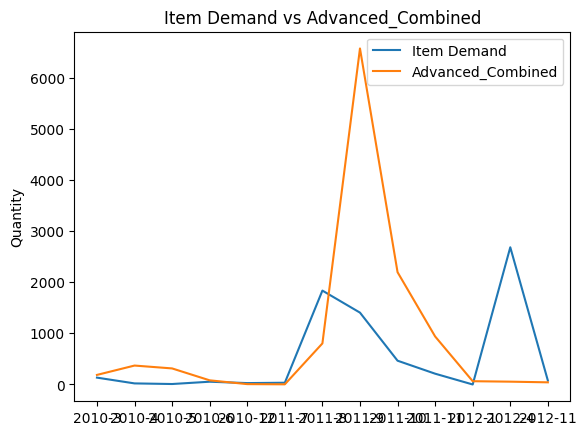

In [317]:
grouped_df = combined_df.groupby(['Order Year', 'Order Month']).agg({'item_demand': 'sum', 'Advanced_Combined': 'sum'}).reset_index()

plt.plot(grouped_df.index, grouped_df['item_demand'], label='Item Demand')
plt.plot(grouped_df.index, grouped_df['Advanced_Combined'], label='Advanced_Combined')

plt.xticks(grouped_df.index, grouped_df['Order Year'].astype(str) + '-' + grouped_df['Order Month'].astype(str))
plt.ylabel('Quantity')
plt.title('Item Demand vs Advanced_Combined')
plt.legend()
plt.show()


In [318]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
avg_actual = y.mean()
mae_ratio = mae / avg_actual
print(f"MAE Ratio: {mae_ratio:.4f}")


Best alpha: 100
Mean Squared Error: 2348153.3282
Mean Absolute Error: 930.4202
MAE Ratio: 1.7389


In [319]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

y_pred = model.predict(X)

predictions = pd.DataFrame({'Year': combined_df['Delivery Year'], 'Month': combined_df['Delivery Month'], 'D_Season_Num': combined_df['D_Season_Num'], 'Actual': y, 'Predicted': y_pred})

print(predictions)


    Year  Month  D_Season_Num  Actual    Predicted
2   2010      3             2     134    68.590505
3   2010      4             2      21   121.141099
4   2010      5             2       9   105.060043
5   2010      6             3      54    38.151363
6   2010     12             1      27    16.901395
7   2011      7             3      34    15.752748
8   2011      8             3    1836  1789.619158
9   2011      9             4    1405  1458.045115
10  2011     10             4     465   291.594409
11  2011     11             4     211   284.536117
12  2012      1             1       0    64.782614
13  2012      4             2    2683    30.685158
14  2012     11             4      77    26.952055


In [320]:
predictions.head()

,Year,Month,D_Season_Num,Actual,Predicted
2,2010,3,2,134,68.590505
3,2010,4,2,21,121.141099
4,2010,5,2,9,105.060043
5,2010,6,3,54,38.151363
6,2010,12,1,27,16.901395


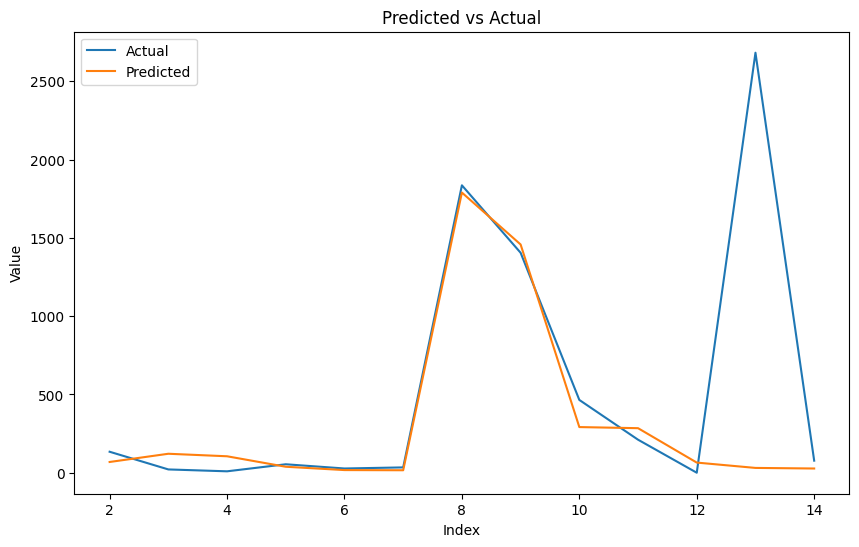

In [321]:
plt.figure(figsize=(10, 6))
plt.plot(predictions['Actual'], label='Actual')
plt.plot(predictions['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()


Now that we have our monthly demand estimates, I will combine them with each seasons product choice probability to find out how the projected demand breaks down to a SKU level.

In [322]:
merged_df = pd.merge(predictions, seasonal_choice_probabilities, left_on='D_Season_Num', right_index=True, how='left')


In [323]:
merged_df.head()

,Year,Month,D_Season_Num,Actual,Predicted,prob_L10705000,prob_L10705100,prob_L10705200,prob_L10705300,prob_L10705400,...,prob_L12918000,prob_L12918400,prob_L12918500,prob_L12918600,prob_L12918700,prob_L12918800,prob_L12918900,prob_L12919000,prob_L12919100,prob_L12919200
2,2010,3,2,134,68.590505,0.001118,0.000408,0.000160,0.000414,0.001099,...,0.003197,0.002731,0.001498,0.000489,0.001737,0.000581,0.000709,0.001988,0.000454,0.003706
3,2010,4,2,21,121.141099,0.001118,0.000408,0.000160,0.000414,0.001099,...,0.003197,0.002731,0.001498,0.000489,0.001737,0.000581,0.000709,0.001988,0.000454,0.003706
4,2010,5,2,9,105.060043,0.001118,0.000408,0.000160,0.000414,0.001099,...,0.003197,0.002731,0.001498,0.000489,0.001737,0.000581,0.000709,0.001988,0.000454,0.003706
5,2010,6,3,54,38.151363,0.013950,0.007616,0.011152,0.013586,0.018328,...,0.051763,0.082740,0.062342,0.045515,0.080479,0.019619,0.031021,0.069495,0.028698,0.073268
6,2010,12,1,27,16.901395,0.001260,0.001093,0.000855,0.001499,0.001424,...,0.000552,0.003433,0.000770,0.002762,0.000733,0.000391,0.002537,0.001801,0.001735,0.003640


In [324]:
merged_df.columns

Index(['Year', 'Month', 'D_Season_Num', 'Actual', 'Predicted',
       'prob_L10705000', 'prob_L10705100', 'prob_L10705200', 'prob_L10705300',
       'prob_L10705400', 'prob_L10705500', 'prob_L10705600', 'prob_L10705700',
       'prob_L10850600', 'prob_L10850700', 'prob_L10850800', 'prob_L10850900',
       'prob_L10852800', 'prob_L10852900', 'prob_L10853100', 'prob_L12134400',
       'prob_L12134500', 'prob_L12134600', 'prob_L12134700', 'prob_L12135800',
       'prob_L12135900', 'prob_L12136000', 'prob_L12136100', 'prob_L12916800',
       'prob_L12916900', 'prob_L12917000', 'prob_L12917100', 'prob_L12917700',
       'prob_L12917800', 'prob_L12917900', 'prob_L12918000', 'prob_L12918400',
       'prob_L12918500', 'prob_L12918600', 'prob_L12918700', 'prob_L12918800',
       'prob_L12918900', 'prob_L12919000', 'prob_L12919100', 'prob_L12919200'],
      dtype='object')

In [325]:
prob_cols = ['prob_L10705000', 'prob_L10705100', 'prob_L10705200', 'prob_L10705300',
    'prob_L10705400', 'prob_L10705500', 'prob_L10705600', 'prob_L10705700',
    'prob_L10850600', 'prob_L10850700', 'prob_L10850800', 'prob_L10850900',
    'prob_L10852800', 'prob_L10852900', 'prob_L10853100', 'prob_L12134400',
    'prob_L12134500', 'prob_L12134600', 'prob_L12134700', 'prob_L12135800',
    'prob_L12135900', 'prob_L12136000', 'prob_L12136100', 'prob_L12916800',
    'prob_L12916900', 'prob_L12917000', 'prob_L12917100', 'prob_L12917700',
    'prob_L12917800', 'prob_L12917900', 'prob_L12918000', 'prob_L12918400',
    'prob_L12918500', 'prob_L12918600', 'prob_L12918700', 'prob_L12918800',
    'prob_L12918900', 'prob_L12919000', 'prob_L12919100', 'prob_L12919200']

new_cols = [col.split('_')[1] for col in prob_cols]

for prob_col, new_col in zip(prob_cols, new_cols):
    merged_df[new_col] = round(merged_df[prob_col] * merged_df['Predicted']).astype(int)


In [326]:
merged_df.head(10)

,Year,Month,D_Season_Num,Actual,Predicted,prob_L10705000,prob_L10705100,prob_L10705200,prob_L10705300,prob_L10705400,...,L12918000,L12918400,L12918500,L12918600,L12918700,L12918800,L12918900,L12919000,L12919100,L12919200
2,2010,3,2,134,68.590505,0.001118,0.000408,0.000160,0.000414,0.001099,...,0,0,0,0,0,0,0,0,0,0
3,2010,4,2,21,121.141099,0.001118,0.000408,0.000160,0.000414,0.001099,...,0,0,0,0,0,0,0,0,0,0
4,2010,5,2,9,105.060043,0.001118,0.000408,0.000160,0.000414,0.001099,...,0,0,0,0,0,0,0,0,0,0
5,2010,6,3,54,38.151363,0.013950,0.007616,0.011152,0.013586,0.018328,...,2,3,2,2,3,1,1,3,1,3
6,2010,12,1,27,16.901395,0.001260,0.001093,0.000855,0.001499,0.001424,...,0,0,0,0,0,0,0,0,0,0
7,2011,7,3,34,15.752748,0.013950,0.007616,0.011152,0.013586,0.018328,...,1,1,1,1,1,0,0,1,0,1
8,2011,8,3,1836,1789.619158,0.013950,0.007616,0.011152,0.013586,0.018328,...,93,148,112,81,144,35,56,124,51,131
9,2011,9,4,1405,1458.045115,0.023947,0.002635,0.000749,0.005558,0.004373,...,120,64,83,39,58,42,108,78,28,100
10,2011,10,4,465,291.594409,0.023947,0.002635,0.000749,0.005558,0.004373,...,24,13,17,8,12,8,22,16,6,20
11,2011,11,4,211,284.536117,0.023947,0.002635,0.000749,0.005558,0.004373,...,23,13,16,8,11,8,21,15,5,20


In [327]:
combined_df.columns

Index(['Order Year', 'Order Month', 'O_Season_Num', 'ordered_items',
       'Urgent Items', 'Advanced_Urgent_Items', 'Advanced_Items',
       'Delivery Year', 'Delivery Month', 'D_Season_Num', 'item_demand',
       'Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month',
       'Advanced_Items_2_months_ago', 'Advanced_Combined'],
      dtype='object')

In [328]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Squared Error: 2366774.8999


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parame

In [329]:
y_pred = model_fit.predict()

predictions_sarima = pd.DataFrame({'Month': combined_df['Order Month'], 'Year': combined_df['Order Year'], 'Actual': y, 'Predicted': y_pred})

print(predictions_sarima)


    Month  Year  Actual     Predicted
2       3  2010     134           NaN
3       4  2010      21  9.000000e+00
4       5  2010       9  3.400000e+01
5       6  2010      54 -1.937114e-13
6      12  2010      27  7.700000e+01
7       7  2011      34  4.650000e+02
8       8  2011    1836  5.400000e+01
9       9  2011    1405  2.700000e+01
10     10  2011     465  0.000000e+00
11     11  2011     211           NaN
12      1  2012       0  1.405000e+03
13      4  2012    2683           NaN
14     11  2012      77  2.100000e+01


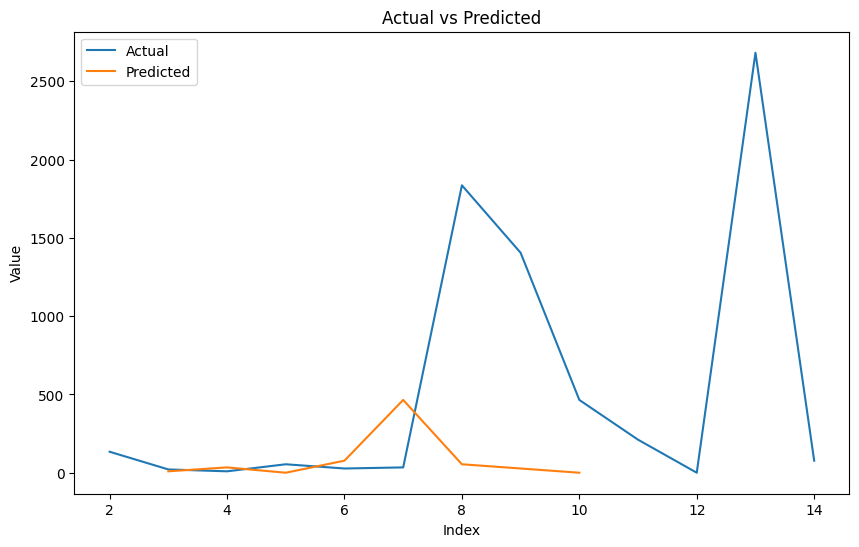

In [330]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_sarima['Actual'], label='Actual')
plt.plot(predictions_sarima['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [331]:
combined_df.tail()

,Order Year,Order Month,O_Season_Num,ordered_items,Urgent Items,Advanced_Urgent_Items,Advanced_Items,Delivery Year,Delivery Month,D_Season_Num,item_demand,Urgent_Items_prev_month,Advanced_Urgent_Items_prev_month,Advanced_Items_2_months_ago,Advanced_Combined
10,2011,10,4,62,0,0,62,2011,10,4,465,44.0,0.0,2196.0,2196.0
11,2011,11,4,57,0,2,55,2011,11,4,211,0.0,0.0,939.0,939.0
12,2012,1,1,42,0,0,42,2012,1,1,0,0.0,2.0,62.0,64.0
13,2012,4,2,7,0,0,7,2012,4,2,2683,0.0,0.0,55.0,55.0
14,2012,11,4,77,77,0,0,2012,11,4,77,0.0,0.0,42.0,42.0


In [332]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)


new_data = pd.DataFrame({'Urgent_Items_prev_month': [combined_df['Urgent_Items_prev_month'].iloc[-1]], 
                         'Advanced_Urgent_Items_prev_month': [combined_df['Advanced_Urgent_Items_prev_month'].iloc[-1]], 
                         'Advanced_Items_2_months_ago': [combined_df['Advanced_Items_2_months_ago'].iloc[-1]]})

prediction = model.predict(new_data)

print(f"Predicted demand for the next month: {prediction[0]:.2f}")


Predicted demand for the next month: 14.90


In [333]:
X = combined_df[['Urgent_Items_prev_month', 'Advanced_Urgent_Items_prev_month', 'Advanced_Items_2_months_ago']]
y = combined_df['item_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ARIMA(y_train, order=(1, 0, 0))
model_fit = model.fit()

y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

mse = mean_squared_error(y_test, y_pred)
print(mse)


2599032.8395944447


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [334]:
y_pred = model_fit.predict()

predictions_arima = pd.DataFrame({'Month': combined_df['Order Month'], 'Year': combined_df['Order Year'], 'Actual': y, 'Predicted': y_pred})

print(predictions_arima)

    Month  Year  Actual   Predicted
2       3  2010     134         NaN
3       4  2010      21  460.490919
4       5  2010       9  452.966448
5       6  2010      54  463.199729
6      12  2010      27  440.024358
7       7  2011      34  323.244564
8       8  2011    1836  446.946871
9       9  2011    1405  455.073300
10     10  2011     465  356.039400
11     11  2011     211         NaN
12      1  2012       0   40.324446
13      4  2012    2683         NaN
14     11  2012      77  456.879173


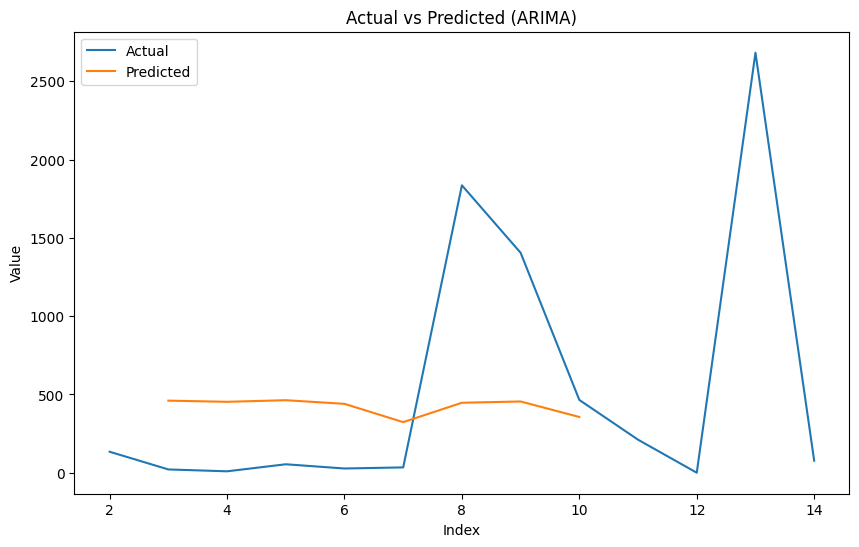

In [335]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_arima['Actual'], label='Actual')
plt.plot(predictions_arima['Predicted'], label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (ARIMA)')
plt.legend()
plt.show()
